In [1]:
import random
import datetime
import pandas as pd
import numpy as np
from haversine import haversine
import folium
from datetime import datetime
import time
from tqdm import tqdm
import gc
import geopy.distance
import seaborn as sns
import shap
import matplotlib.pyplot as plt

## Data preprocessing

In [3]:
df1 = pd.read_csv("data/gps_fulldata_20220512_20220819.csv", encoding='shift_jis', usecols=[0,1,2,4,6])
df1

,vehicleCode,lat,lng,timestamp,distance
0,W46-スポット,34.640898,133.966966,2022-05-12T10:17:32+09:00,0.000000
1,W46-スポット,34.640920,133.966956,2022-05-12T10:27:28+09:00,2.607085
2,W46-スポット,34.640933,133.966950,2022-05-12T10:48:50+09:00,1.543501
3,W46-スポット,34.641057,133.966894,2022-05-12T10:48:55+09:00,14.682787
4,W46-スポット,34.641229,133.966861,2022-05-12T10:49:00+09:00,19.319046
...,...,...,...,...,...
18876064,W1,35.082180,136.932447,2022-08-19T07:08:17+09:00,0.000000
18876065,W1,35.082399,136.932265,2022-08-19T07:08:29+09:00,29.424443
18876066,W1,35.082374,136.932283,2022-08-19T07:08:34+09:00,3.222924
18876067,W1,35.082375,136.932268,2022-08-19T07:08:40+09:00,1.372440


In [4]:
df2 = pd.read_csv("data/gps_20220820_20221107.csv", encoding='shift_jis', header=None, usecols=[0,1,2,4,6], names=df1.columns)
df2

,vehicleCode,lat,lng,timestamp,distance
0,W46-スポット,34.640362,133.966977,2022-08-23T07:54:19+09:00,0.000000
1,W46-スポット,34.640391,133.966973,2022-08-23T07:54:33+09:00,0.000000
2,W46-スポット,34.640391,133.966973,2022-08-23T07:54:34+09:00,0.000000
3,W46-スポット,34.640651,133.967012,2022-08-23T08:04:27+09:00,29.063645
4,W46-スポット,34.640643,133.967039,2022-08-23T08:23:20+09:00,2.629780
...,...,...,...,...,...
14963701,W1,35.081417,136.931780,2022-11-04T18:37:21+09:00,12.617725
14963702,W1,35.081387,136.931712,2022-11-04T18:37:26+09:00,7.038125
14963703,W1,35.081454,136.931645,2022-11-04T18:37:31+09:00,9.622178
14963704,W1,35.081527,136.931603,2022-11-04T18:37:36+09:00,8.958866


In [5]:
df = pd.concat([df1, df2],axis=0)
df.sort_values(by=['vehicleCode', 'timestamp'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,vehicleCode,lat,lng,timestamp,distance
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186
...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303


In [6]:
del [[df1, df2]]
gc.collect()
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33839775 entries, 0 to 33839774
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   vehicleCode  object 
 1   lat          float64
 2   lng          float64
 3   timestamp    object 
 4   distance     float64
dtypes: float64(3), object(2)
memory usage: 1.3+ GB


### Target Segment With Radi
- location : make tuple like (lat, lng)
- is_in_target : 
    - we have 4 target
    - i if location is in the target i (i = 1, 2, 3, 4)
    - 0 if not

We use only data passing through the target
- 33839775 rows -> 27092775 rows
- 93 vehicleCode -> 69 vehicleCode

In [8]:
def get_gps_distance(location, radi):
    for i in range(1, 5):
        if(haversine(location, target_place[str(i)]) < radi):
            return i
    return 0

In [9]:
target_place = {}
target_place['1'] = (35.50114245663584, 139.77058608966317)
target_place['2'] = (35.55767062747489, 139.6647807694566)
target_place['3'] = (35.47113783648265, 139.36696119089578)
target_place['4'] = (35.52031899275968, 139.35217137718712)

radi = 0.7 # 여러개로 실험 가능 700m
df['is_in_target'] = df[['lat','lng']].apply(lambda x : get_gps_distance(tuple(x.values), radi), axis=1)
df.head()

,vehicleCode,lat,lng,timestamp,distance,is_in_target
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000,0
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071,0
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148,0
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548,0
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186,0


In [10]:
target_pass_result= list(df[df['is_in_target']!=0]['vehicleCode'].unique())
print(target_pass_result)

['W102', 'W103', 'W104', 'W105', 'W106', 'W108', 'W109', 'W110', 'W111', 'W112', 'W113', 'W114', 'W115', 'W117', 'W118', 'W119', 'W120-1', 'W120-2', 'W40-1', 'W40-2', 'W41-1', 'W41-2', 'W42-1', 'W42-2', 'W44-1', 'W44-2', 'W44-スポット', 'W45-1', 'W45-2', 'W46', 'W46-スポット', 'W47-1', 'W47-2', 'W47-3', 'W52', 'W53', 'W54', 'W69', 'W70', 'W71', 'W72', 'W73', 'W74', 'W75', 'W76', 'W77', 'W78', 'W79', 'W80', 'W82-2', 'W83-1', 'W83-2', 'W83-3', 'W84', 'W86', 'W87-1', 'W87-2', 'W88', 'W90', 'W91', 'W92-1', 'W93-1', 'W93-2', 'W94', 'W95-1', 'W95-2', 'W97-1', 'W97-2', 'W98-1', 'W98-2', '座間エンジン（1・2・4時区）-1', '座間エンジン（1・2・4時区）-2', '座間エンジン（3時区）-1', '座間エンジン（3時区）-2']


In [11]:
target_df= df[df['vehicleCode'].isin(target_pass_result)]
target_df.reset_index(drop=True, inplace=True)
target_df

,vehicleCode,lat,lng,timestamp,distance,is_in_target
0,W102,35.534938,139.651564,2022-05-12T03:49:19+09:00,40.923383,0
1,W102,35.534921,139.651580,2022-05-12T03:49:20+09:00,2.379729,0
2,W102,35.534921,139.651580,2022-05-12T03:49:24+09:00,0.000000,0
3,W102,35.534921,139.651580,2022-05-12T03:49:29+09:00,0.000000,0
4,W102,35.534976,139.651498,2022-05-12T03:49:31+09:00,9.619799,0
...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,0


In [12]:
target_df['is_in_target'].value_counts(normalize=True)

0    0.927852
2    0.045563
1    0.010662
4    0.010287
3    0.005636
Name: is_in_target, dtype: float64

### Determination of arrival status
- del_time : Time difference between before and now
- course : In same vehicleCode, seperate different drive
    - criterion : del_time >= 3 hours
- segmentation_point : Get O at the moment the is_in_target changes
- final_seg_point : Get O at Estimated Arrivals (vehicle stop point)
    - criterion : 10 minutes after entering the target area

In [13]:
import datetime
target_df['timestamp']=target_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))

serials = target_df['vehicleCode'].unique()
for serial in serials:
    target_df.loc[target_df.vehicleCode==serial, 'del_time'] = \
    np.append(0, (target_df.loc[target_df.vehicleCode==serial, 'timestamp'][1:].reset_index(drop=True)-target_df.loc[target_df.vehicleCode==serial, 'timestamp'][:-1].reset_index(drop=True)).apply(lambda x: x.seconds).values)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# more than 3 hours -> new course
vehicleCodes=target_df['vehicleCode'].unique()
idx = list(target_df[target_df['del_time']>3*60*60].index)

for i in vehicleCodes:
    idx.append(target_df[target_df['vehicleCode']==i].index[0])
    
idx=sorted(list(set(idx)))

target_df.loc[0, 'course'] = 0
target_df.loc[idx, 'course'] = np.arange(1, len(idx)+1)
target_df['course'].fillna(method='ffill', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
courses=target_df['course'].unique()
idx=[]
for i in courses:
    idx.append(target_df[target_df['course']==i].index[0])

target_df.loc[idx, 'del_time'] = 0

In [16]:
target_df['temp'] = target_df['is_in_target'].shift(periods=1, fill_value=0)
target_df['segmentation_point'] = target_df.apply(lambda x : "O" if x['is_in_target']!= x['temp'] else "X", axis=1)

In [17]:
from tqdm import tqdm
target_df['final_seg_point'] = "X"

# criterion : 10 minutes after entering the target area
for i in tqdm(target_df[target_df['segmentation_point']=='O'].index):
    now = i
    while(target_df['course'][now]==target_df['course'][i]):
        now += 1
        if((target_df['timestamp'][now]-target_df['timestamp'][i]).total_seconds()>600):
            if(target_df['is_in_target'][now] == target_df['is_in_target'][i]):
                target_df.loc[now,'final_seg_point'] ='O'
                break
            else:
                break

100%|███████████████████████████████████████████████████████████████████████████| 37431/37431 [02:40<00:00, 233.41it/s]


In [18]:
target_df['segmentation_point'].value_counts()

X    28005944
O       37431
Name: segmentation_point, dtype: int64

In [19]:
target_df['final_seg_point'].value_counts()

X    28012888
O       30487
Name: final_seg_point, dtype: int64

In [20]:
target_df.drop(['temp', 'segmentation_point'], axis=1, inplace=True)

In [21]:
target_df['course'] = target_df['course'].astype('int')

## feature
- velocity
- weekday
- velocity_mean_sec
- velocity_std_sec
- velocity_mean_day
- velocity_std_day
- left_time
- total_distance
- left_distance
- time_cum_sum
- total_time
- route_name

In [22]:
target_df['velocity'] = target_df['distance']/target_df['del_time']

In [23]:
target_df['weekday'] = target_df['timestamp'].dt.weekday
target_df['five_sec'] = target_df['timestamp'].dt.round('5s').dt.time
target_df['five_sec'] = target_df['five_sec'].apply(lambda x: x.strftime("%H:%M:%S"))
target_df = target_df.fillna(0)
target_df.loc[target_df['velocity']==np.inf, 'velocity'] = 0

In [27]:
a = pd.DataFrame(target_df.groupby('five_sec')['velocity'].mean())
a.rename(columns = {'velocity':'velocity_mean_5sec'},inplace=True)
b = pd.DataFrame(target_df.groupby('five_sec')['velocity'].std())
b.rename(columns = {'velocity':'velocity_std_5sec'},inplace=True)
df1=pd.concat([a,b],axis=1).reset_index()

In [31]:
c = pd.DataFrame(target_df.groupby('weekday')['velocity'].mean())
c.rename(columns = {'velocity':'velocity_mean_weekday'},inplace=True)
d = pd.DataFrame(target_df.groupby('weekday')['velocity'].std())
d.rename(columns = {'velocity':'velocity_std_weekday'},inplace=True)
df2=pd.concat([c,d],axis=1).reset_index()

In [34]:
target_df = pd.merge(target_df, df1, on='five_sec', how='left')
target_df = pd.merge(target_df, df2, on='weekday', how='left')

In [40]:
# vehicleCode별로 코스의 총거리 평균
e = pd.DataFrame(target_df.groupby(["vehicleCode","course"]).distance.sum().reset_index().groupby('vehicleCode').distance.mean())
e.rename(columns = {'distance':'total_distance_mean_vehicle'},inplace=True)
# vehicleCode별로 코스의 총시간 평균
f = pd.DataFrame(target_df.groupby(["vehicleCode","course"]).del_time.sum().reset_index().groupby('vehicleCode').del_time.mean())
f.rename(columns = {'del_time':'total_time_mean_vehicle'},inplace=True)
df3=pd.concat([e,f],axis=1).reset_index()

In [42]:
target_df = pd.merge(target_df, df3, on='vehicleCode', how='left')

In [61]:
#df1.to_csv('../data/constant_velocity_5sec.csv',index=False)
#df2.to_csv('../data/constant_velocity_weekday.csv',index=False)
#df3.to_csv('../data/constant_total_distance_time.csv',index=False, encoding='shift_jis')

In [48]:
#accumulative distance per course
target_df['cum_sum_distance'] = target_df.groupby("course").distance.cumsum()

#total distance per course
total_distance = target_df.groupby("course").distance.sum()

# mapping target_df with total distance per course
target_df['total_distance']= target_df.course.apply(lambda x : total_distance[x])

# left_distance per course
target_df['left_distance'] = target_df['total_distance'] - target_df['cum_sum_distance']

In [49]:
#accumulative time per course
target_df['cum_sum_time'] = target_df.groupby("course").del_time.cumsum()

#total time_consumption per course
total_time = target_df.groupby("course").del_time.sum()

# mapping target_df with total tite_consumption per course
target_df['total_time']= target_df.course.apply(lambda x : total_time[x])

# left_time per course
target_df['left_time'] = target_df['total_time'] - target_df['cum_sum_time']

In [56]:
target_df['start']=target_df['is_in_target']
target_df['end']=target_df['is_in_target']
target_df['start'].replace(0, np.NaN,inplace=True)
target_df['end'].replace(0, np.NaN,inplace=True)

courses=target_df['course'].unique()
courses.sort()


idx=[]
for i in courses:
    idx.append(target_df[target_df['course']==i].index[0])
target_df.loc[idx, 'start'] = 0
target_df.loc[idx, 'end'] = 0


if np.isnan(target_df['end'].iloc[-1]):
    target_df['end'].iloc[-1]=0
target_df['start'].fillna(method='ffill', inplace=True)
target_df['end'].fillna(method='bfill', inplace=True)

target_df['route_name']=target_df['start'].astype('int').astype('str')+target_df['end'].astype('int').astype('str')+target_df['vehicleCode']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28043375 entries, 0 to 28043374
Data columns (total 27 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   vehicleCode                  object        
 1   lat                          float64       
 2   lng                          float64       
 3   timestamp                    datetime64[ns]
 4   distance                     float64       
 5   is_in_target                 int64         
 6   del_time                     float64       
 7   course                       int64         
 8   final_seg_point              object        
 9   velocity                     float64       
 10  weekday                      int64         
 11  five_sec                     object        
 12  velocity_mean_5sec           float64       
 13  velocity_std_5sec            float64       
 14  velocity_mean_weekday        float64       
 15  velocity_std_weekday         float64       
 16

In [58]:
target_df.head()

,vehicleCode,lat,lng,timestamp,distance,is_in_target,del_time,course,final_seg_point,velocity,...,total_time_mean_vehicle,cum_sum_distance,left_distance,cum_sum_time,left_time,total_distance,total_time,start,end,route_name
0,W102,35.534938,139.651564,2022-05-12 03:49:19,40.923383,0,0.0,1,X,0.000000,...,43944.075758,40.923383,121007.184836,0.0,46228.0,121048.108219,46228.0,0.0,0.0,00W102
1,W102,35.534921,139.651580,2022-05-12 03:49:20,2.379729,0,1.0,1,X,2.379729,...,43944.075758,43.303112,121004.805107,1.0,46227.0,121048.108219,46228.0,0.0,2.0,02W102
2,W102,35.534921,139.651580,2022-05-12 03:49:24,0.000000,0,4.0,1,X,0.000000,...,43944.075758,43.303112,121004.805107,5.0,46223.0,121048.108219,46228.0,0.0,2.0,02W102
3,W102,35.534921,139.651580,2022-05-12 03:49:29,0.000000,0,5.0,1,X,0.000000,...,43944.075758,43.303112,121004.805107,10.0,46218.0,121048.108219,46228.0,0.0,2.0,02W102
4,W102,35.534976,139.651498,2022-05-12 03:49:31,9.619799,0,2.0,1,X,4.809900,...,43944.075758,52.922911,120995.185308,12.0,46216.0,121048.108219,46228.0,0.0,2.0,02W102


In [59]:
target_df.to_csv('../data/1208_preprocessed_dataset.csv',index=False, encoding='shift_jis')

## Modeling

In [4]:
#import preprocessed_Dataset
data = pd.read_csv("1208_preprocessed_dataset.csv", encoding='shift_jis')
data.head()

,vehicleCode,lat,lng,timestamp,distance,is_in_target,del_time,course,final_seg_point,velocity,...,total_time_mean_vehicle,cum_sum_distance,left_distance,cum_sum_time,left_time,total_distance,total_time,start,end,route_name
0,W102,35.534938,139.651564,2022-05-12 03:49:19,40.923383,0,0.0,1,X,0.000000,...,43944.075758,40.923383,121007.184836,0.0,46228.0,121048.108219,46228.0,0.0,0.0,00W102
1,W102,35.534921,139.651580,2022-05-12 03:49:20,2.379729,0,1.0,1,X,2.379729,...,43944.075758,43.303112,121004.805107,1.0,46227.0,121048.108219,46228.0,0.0,2.0,02W102
2,W102,35.534921,139.651580,2022-05-12 03:49:24,0.000000,0,4.0,1,X,0.000000,...,43944.075758,43.303112,121004.805107,5.0,46223.0,121048.108219,46228.0,0.0,2.0,02W102
3,W102,35.534921,139.651580,2022-05-12 03:49:29,0.000000,0,5.0,1,X,0.000000,...,43944.075758,43.303112,121004.805107,10.0,46218.0,121048.108219,46228.0,0.0,2.0,02W102
4,W102,35.534976,139.651498,2022-05-12 03:49:31,9.619799,0,2.0,1,X,4.809900,...,43944.075758,52.922911,120995.185308,12.0,46216.0,121048.108219,46228.0,0.0,2.0,02W102


In [7]:
data.columns

Index(['vehicleCode', 'lat', 'lng', 'timestamp', 'distance', 'is_in_target',
       'del_time', 'course', 'final_seg_point', 'velocity', 'weekday',
       'five_sec', 'velocity_mean_5sec', 'velocity_std_5sec',
       'velocity_mean_weekday', 'velocity_std_weekday',
       'total_distance_mean_vehicle', 'total_time_mean_vehicle',
       'cum_sum_distance', 'left_distance', 'cum_sum_time', 'left_time',
       'total_distance', 'total_time', 'start', 'end', 'route_name'],
      dtype='object')

In [8]:
# in our model, only certain feature will be used (below features)
final_data=data[['vehicleCode', 'lat', 'lng', 'velocity', 'distance', 'is_in_target','course','total_distance_mean_vehicle','left_distance', 'cum_sum_time', 'total_time','route_name','weekday', 'velocity_mean_5sec', 'velocity_std_5sec','velocity_mean_weekday', 'velocity_std_weekday','left_time']]

In [9]:
# make y value into minutes scale
final_data['left_time'] = final_data['left_time'].apply(lambda x : int(x/60))
final_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance_mean_vehicle,left_distance,cum_sum_time,total_time,route_name,weekday,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1,112856.851854,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855925,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1,112856.851854,121004.805107,1.0,46228.0,02W102,3,12.714170,8.451423,14.855925,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,5.0,46228.0,02W102,3,12.761008,9.212830,14.855925,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,10.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1,112856.851854,120995.185308,12.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,0.824342,4.121708,0,8951,119612.038095,20.369249,36399.0,36420.0,30座間エンジン（3時区）-2,4,15.459545,59.483187,12.702903,49.704713,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,0.309787,1.858719,0,8951,119612.038095,18.510530,36405.0,36420.0,30座間エンジン（3時区）-2,4,18.548741,123.468030,12.702903,49.704713,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2.100748,10.503742,0,8951,119612.038095,8.006789,36410.0,36420.0,30座間エンジン（3時区）-2,4,16.145609,48.045460,12.702903,49.704713,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,1.334461,6.672303,0,8951,119612.038095,1.334485,36415.0,36420.0,30座間エンジン（3時区）-2,4,16.078983,59.840919,12.702903,49.704713,0


### For making model more precisely, select validated course data

- By using IQR, delete the course that has too less timestamp
- Only course that passing through 4 of target place will be considered

In [10]:
s = pd.DataFrame(data.groupby("course")['is_in_target'])
not_pass_target = []
for i in range(len(s)):
    if(s.iloc[i][1].sum()==0):
        not_pass_target.append(i+1)

In [11]:
len(not_pass_target)

2374

In [12]:
final_data = final_data[~final_data['course'].isin(not_pass_target)]
final_data.head()

,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance_mean_vehicle,left_distance,cum_sum_time,total_time,route_name,weekday,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1,112856.851854,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855925,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1,112856.851854,121004.805107,1.0,46228.0,02W102,3,12.714170,8.451423,14.855925,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,5.0,46228.0,02W102,3,12.761008,9.212830,14.855925,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,10.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1,112856.851854,120995.185308,12.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770


In [13]:
temp = pd.DataFrame(final_data.groupby(['vehicleCode','course']).count())

Q1 = temp.groupby("vehicleCode")['lat'].describe()["25%"]
Q3 = temp.groupby("vehicleCode")['lat'].describe()["75%"]
IQR = Q3-Q1
min_limit = Q1-1.5*IQR
min_limit_dic = {}

for _,b in enumerate(min_limit.items()):
    min_limit_dic[b[0]] =b[1]

In [14]:
min_limit_dic

{'W102': 2527.25,
 'W103': -1073.5,
 'W104': 1351.75,
 'W105': 883.25,
 'W106': 1587.5,
 'W108': 3466.0,
 'W109': 3716.5,
 'W110': -3317.5,
 'W111': 1738.5,
 'W112': 1017.625,
 'W113': 2024.75,
 'W114': 2384.25,
 'W115': 1071.25,
 'W117': 845.875,
 'W118': 94.0,
 'W119': 2286.5,
 'W120-1': -1074.0,
 'W120-2': 785.0,
 'W40-1': -2215.5,
 'W40-2': -4454.0,
 'W41-1': 2265.5,
 'W41-2': -3393.875,
 'W42-1': 2485.75,
 'W42-2': -2931.125,
 'W44-1': 4038.0,
 'W44-2': 4821.0,
 'W44-スポット': 1665.75,
 'W45-1': 5395.5,
 'W45-2': 4557.125,
 'W46': 4372.375,
 'W46-スポット': 847.125,
 'W47-1': 2970.625,
 'W47-2': -2875.0,
 'W47-3': 3402.375,
 'W52': 1880.375,
 'W53': 1355.625,
 'W54': 1843.5,
 'W69': 2750.75,
 'W70': 2583.25,
 'W71': 242.5,
 'W72': 1728.25,
 'W73': 3923.0,
 'W74': 3883.5,
 'W75': -804.75,
 'W76': 1384.0,
 'W77': 1801.75,
 'W78': 3841.0,
 'W79': 1865.0,
 'W80': 1752.5,
 'W82-2': 3674.5,
 'W83-1': 66.0,
 'W83-2': 2191.5,
 'W83-3': 5037.875,
 'W84': 2188.625,
 'W86': 1480.0,
 'W87-1': 796.12

In [15]:
s = final_data.groupby(['vehicleCode',"course"])['vehicleCode'].count()
not_used = []
for key in min_limit_dic.keys():
    for _,i in enumerate(s[key].items()):        
        if(i[1]<min_limit_dic[key]):
            not_used.append(i[0])
len(not_used)

256

In [83]:
selected_data = final_data[~final_data['course'].isin(not_used)]
selected_data

,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance_mean_vehicle,left_distance,cum_sum_time,total_time,route_name,weekday,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1,112856.851854,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855925,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1,112856.851854,121004.805107,1.0,46228.0,02W102,3,12.714170,8.451423,14.855925,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,5.0,46228.0,02W102,3,12.761008,9.212830,14.855925,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1,112856.851854,121004.805107,10.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1,112856.851854,120995.185308,12.0,46228.0,02W102,3,14.166098,40.625645,14.855925,1382.331636,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,0.824342,4.121708,0,8951,119612.038095,20.369249,36399.0,36420.0,30座間エンジン（3時区）-2,4,15.459545,59.483187,12.702903,49.704713,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,0.309787,1.858719,0,8951,119612.038095,18.510530,36405.0,36420.0,30座間エンジン（3時区）-2,4,18.548741,123.468030,12.702903,49.704713,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2.100748,10.503742,0,8951,119612.038095,8.006789,36410.0,36420.0,30座間エンジン（3時区）-2,4,16.145609,48.045460,12.702903,49.704713,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,1.334461,6.672303,0,8951,119612.038095,1.334485,36415.0,36420.0,30座間エンジン（3時区）-2,4,16.078983,59.840919,12.702903,49.704713,0


In [ ]:
selected_data = selected_data.drop('course',axis=1)

### train, test split

- split the dataset into (train, test) with course-wise by vehicleCode


In [19]:
import random
temp = pd.DataFrame(selected_data.groupby("vehicleCode").course)
random.seed =1
test_course = []
for i in range(len(temp)):
    t = temp[1][i].values
    set_t = set(t)
    idx = random.sample(set_t,int(len(set_t)/8))
    set_t = list(set_t)
    test_course.extend(idx)
    

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


In [84]:
test_data = selected_data[selected_data['course'].isin(test_course)]
train_data = selected_data[~selected_data['course'].isin(test_course)]
print("train_data len is {}".format(len(train_data)))
print("test_data len is {}".format(len(test_data)))

train_data len is 18841097
test_data len is 2539465


In [42]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
seed =1422
model1= CatBoostRegressor(
                          eval_metric = 'RMSE',
                          cat_features = ['vehicleCode','route_name','is_in_target','weekday'],
                          random_state=seed,
                         verbose = True)

X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

model1.fit(X_train , y_train)

Learning rate set to 0.193931
0:	learn: 284.0617087	total: 9.14s	remaining: 2h 32m 8s
1:	learn: 243.9192328	total: 16.3s	remaining: 2h 15m 34s
2:	learn: 211.0325972	total: 23.7s	remaining: 2h 11m 13s
3:	learn: 184.4189299	total: 29.6s	remaining: 2h 2m 58s
4:	learn: 160.4118834	total: 35.9s	remaining: 1h 58m 55s
5:	learn: 142.9313925	total: 42.6s	remaining: 1h 57m 35s
6:	learn: 126.5719143	total: 48.4s	remaining: 1h 54m 30s
7:	learn: 112.4461783	total: 54.8s	remaining: 1h 53m 11s
8:	learn: 101.0364857	total: 1m	remaining: 1h 51m 14s
9:	learn: 92.3477073	total: 1m 6s	remaining: 1h 49m 18s
10:	learn: 83.8005335	total: 1m 11s	remaining: 1h 46m 40s
11:	learn: 76.9535521	total: 1m 16s	remaining: 1h 45m 8s
12:	learn: 71.2004975	total: 1m 22s	remaining: 1h 44m 10s
13:	learn: 66.5884823	total: 1m 27s	remaining: 1h 42m 55s
14:	learn: 62.9199824	total: 1m 33s	remaining: 1h 42m 10s
15:	learn: 59.8192039	total: 1m 38s	remaining: 1h 41m 4s
16:	learn: 57.1118029	total: 1m 44s	remaining: 1h 40m 29s
17

141:	learn: 16.5934883	total: 13m 12s	remaining: 1h 19m 48s
142:	learn: 16.5484022	total: 13m 18s	remaining: 1h 19m 45s
143:	learn: 16.5024522	total: 13m 23s	remaining: 1h 19m 37s
144:	learn: 16.4144840	total: 13m 29s	remaining: 1h 19m 30s
145:	learn: 16.3621879	total: 13m 34s	remaining: 1h 19m 23s
146:	learn: 16.2922915	total: 13m 39s	remaining: 1h 19m 16s
147:	learn: 16.2261558	total: 13m 45s	remaining: 1h 19m 11s
148:	learn: 16.1901127	total: 13m 50s	remaining: 1h 19m 4s
149:	learn: 16.1207756	total: 13m 56s	remaining: 1h 18m 59s
150:	learn: 16.0383982	total: 14m 1s	remaining: 1h 18m 51s
151:	learn: 15.9631169	total: 14m 6s	remaining: 1h 18m 44s
152:	learn: 15.9137925	total: 14m 12s	remaining: 1h 18m 40s
153:	learn: 15.8637438	total: 14m 18s	remaining: 1h 18m 33s
154:	learn: 15.8310840	total: 14m 24s	remaining: 1h 18m 31s
155:	learn: 15.7735892	total: 14m 29s	remaining: 1h 18m 25s
156:	learn: 15.7396765	total: 14m 35s	remaining: 1h 18m 19s
157:	learn: 15.7001663	total: 14m 40s	remai

280:	learn: 11.6671406	total: 25m 58s	remaining: 1h 6m 28s
281:	learn: 11.6461266	total: 26m 4s	remaining: 1h 6m 23s
282:	learn: 11.6301142	total: 26m 10s	remaining: 1h 6m 18s
283:	learn: 11.6147060	total: 26m 15s	remaining: 1h 6m 13s
284:	learn: 11.5937715	total: 26m 21s	remaining: 1h 6m 7s
285:	learn: 11.5671159	total: 26m 27s	remaining: 1h 6m 2s
286:	learn: 11.5267892	total: 26m 31s	remaining: 1h 5m 54s
287:	learn: 11.5109674	total: 26m 37s	remaining: 1h 5m 50s
288:	learn: 11.4269983	total: 26m 43s	remaining: 1h 5m 45s
289:	learn: 11.4078505	total: 26m 48s	remaining: 1h 5m 38s
290:	learn: 11.3885987	total: 26m 54s	remaining: 1h 5m 33s
291:	learn: 11.3408939	total: 26m 59s	remaining: 1h 5m 25s
292:	learn: 11.3200708	total: 27m 5s	remaining: 1h 5m 21s
293:	learn: 11.2865998	total: 27m 11s	remaining: 1h 5m 16s
294:	learn: 11.2556449	total: 27m 16s	remaining: 1h 5m 10s
295:	learn: 11.2379509	total: 27m 21s	remaining: 1h 5m 4s
296:	learn: 11.2191107	total: 27m 27s	remaining: 1h 4m 58s
29

424:	learn: 9.2930072	total: 39m 7s	remaining: 52m 56s
425:	learn: 9.2835455	total: 39m 13s	remaining: 52m 51s
426:	learn: 9.2697229	total: 39m 19s	remaining: 52m 45s
427:	learn: 9.2621338	total: 39m 24s	remaining: 52m 40s
428:	learn: 9.2498100	total: 39m 29s	remaining: 52m 34s
429:	learn: 9.2431599	total: 39m 35s	remaining: 52m 29s
430:	learn: 9.2309535	total: 39m 41s	remaining: 52m 24s
431:	learn: 9.2099097	total: 39m 46s	remaining: 52m 17s
432:	learn: 9.1926772	total: 39m 51s	remaining: 52m 11s
433:	learn: 9.1806252	total: 39m 57s	remaining: 52m 6s
434:	learn: 9.1746976	total: 40m 2s	remaining: 52m
435:	learn: 9.1653600	total: 40m 7s	remaining: 51m 54s
436:	learn: 9.1559266	total: 40m 12s	remaining: 51m 48s
437:	learn: 9.1472428	total: 40m 18s	remaining: 51m 42s
438:	learn: 9.1391891	total: 40m 24s	remaining: 51m 37s
439:	learn: 9.1288394	total: 40m 29s	remaining: 51m 32s
440:	learn: 9.1182312	total: 40m 34s	remaining: 51m 26s
441:	learn: 9.1063330	total: 40m 40s	remaining: 51m 20s


572:	learn: 7.9710760	total: 52m 35s	remaining: 39m 11s
573:	learn: 7.9620358	total: 52m 40s	remaining: 39m 5s
574:	learn: 7.9580753	total: 52m 46s	remaining: 39m
575:	learn: 7.9533883	total: 52m 52s	remaining: 38m 54s
576:	learn: 7.9462913	total: 52m 57s	remaining: 38m 49s
577:	learn: 7.9316119	total: 53m 2s	remaining: 38m 43s
578:	learn: 7.9263223	total: 53m 8s	remaining: 38m 38s
579:	learn: 7.9202926	total: 53m 13s	remaining: 38m 32s
580:	learn: 7.9132677	total: 53m 18s	remaining: 38m 27s
581:	learn: 7.9063594	total: 53m 23s	remaining: 38m 21s
582:	learn: 7.8976964	total: 53m 29s	remaining: 38m 15s
583:	learn: 7.8912152	total: 53m 34s	remaining: 38m 9s
584:	learn: 7.8799505	total: 53m 40s	remaining: 38m 4s
585:	learn: 7.8728697	total: 53m 46s	remaining: 37m 59s
586:	learn: 7.8649641	total: 53m 53s	remaining: 37m 54s
587:	learn: 7.8593331	total: 53m 59s	remaining: 37m 49s
588:	learn: 7.8538522	total: 54m 4s	remaining: 37m 43s
589:	learn: 7.8442266	total: 54m 9s	remaining: 37m 38s
590

718:	learn: 7.1338865	total: 1h 5m 49s	remaining: 25m 43s
719:	learn: 7.1276838	total: 1h 5m 55s	remaining: 25m 38s
720:	learn: 7.1228194	total: 1h 6m	remaining: 25m 32s
721:	learn: 7.1184283	total: 1h 6m 6s	remaining: 25m 27s
722:	learn: 7.1091471	total: 1h 6m 11s	remaining: 25m 21s
723:	learn: 7.1060574	total: 1h 6m 17s	remaining: 25m 16s
724:	learn: 7.0983044	total: 1h 6m 23s	remaining: 25m 10s
725:	learn: 7.0939945	total: 1h 6m 28s	remaining: 25m 5s
726:	learn: 7.0883794	total: 1h 6m 34s	remaining: 25m
727:	learn: 7.0860149	total: 1h 6m 40s	remaining: 24m 54s
728:	learn: 7.0831268	total: 1h 6m 45s	remaining: 24m 49s
729:	learn: 7.0805920	total: 1h 6m 51s	remaining: 24m 43s
730:	learn: 7.0773275	total: 1h 6m 56s	remaining: 24m 37s
731:	learn: 7.0729523	total: 1h 7m 2s	remaining: 24m 32s
732:	learn: 7.0705169	total: 1h 7m 8s	remaining: 24m 27s
733:	learn: 7.0662208	total: 1h 7m 16s	remaining: 24m 22s
734:	learn: 7.0610854	total: 1h 7m 22s	remaining: 24m 17s
735:	learn: 7.0543347	tota

859:	learn: 6.5484435	total: 1h 18m 45s	remaining: 12m 49s
860:	learn: 6.5448816	total: 1h 18m 50s	remaining: 12m 43s
861:	learn: 6.5404435	total: 1h 18m 56s	remaining: 12m 38s
862:	learn: 6.5390502	total: 1h 19m 1s	remaining: 12m 32s
863:	learn: 6.5365794	total: 1h 19m 7s	remaining: 12m 27s
864:	learn: 6.5342335	total: 1h 19m 12s	remaining: 12m 21s
865:	learn: 6.5315164	total: 1h 19m 17s	remaining: 12m 16s
866:	learn: 6.5256295	total: 1h 19m 22s	remaining: 12m 10s
867:	learn: 6.5227875	total: 1h 19m 28s	remaining: 12m 5s
868:	learn: 6.5208363	total: 1h 19m 33s	remaining: 11m 59s
869:	learn: 6.5186512	total: 1h 19m 39s	remaining: 11m 54s
870:	learn: 6.5140908	total: 1h 19m 44s	remaining: 11m 48s
871:	learn: 6.5112646	total: 1h 19m 50s	remaining: 11m 43s
872:	learn: 6.5083229	total: 1h 19m 55s	remaining: 11m 37s
873:	learn: 6.5051054	total: 1h 20m 1s	remaining: 11m 32s
874:	learn: 6.5015742	total: 1h 20m 6s	remaining: 11m 26s
875:	learn: 6.4992571	total: 1h 20m 11s	remaining: 11m 21s
87

In [2]:
import pickle
# 파일명
filename = 'final_model_insight.model'

# 모델 저장
pickle.dump(model1, open(filename, 'wb'))

In [110]:
# check the performance

from sklearn.metrics import mean_squared_error, r2_score
pred = model1.predict(X_test)
mse = mean_squared_error(y_test , pred)
r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(mse)}')
print(f'r2 : {r2}')

rmse : 11.890973595281583
r2 : 0.9983619446736846


In [97]:
# RMSE by VehicleCode

from tqdm import tqdm
vehicleCode = test_data['vehicleCode'].unique()
res = []
for vehicle in tqdm(vehicleCode):
    temp = test_data[test_data['vehicleCode']==vehicle]
    X_temp = temp.iloc[:, :-1]
    y_temp= temp.iloc[:, -1]
    pred = model1.predict(X_temp)
    mse = mean_squared_error(y_temp , pred)
    rmse = np.sqrt(mse)
    res.append(rmse)
    #r2 = r2_score(y_test, pred)
    print("vehicle code : {} , rmse : {}".format(vehicle, rmse))
    #print(f'r2 : {r2}')
    

  3%|▎         | 2/73 [00:00<00:11,  6.10it/s]

vehicle code : W102 , rmse : 2.440710285094783
vehicle code : W103 , rmse : 10.401355358940952


  5%|▌         | 4/73 [00:00<00:10,  6.81it/s]

vehicle code : W104 , rmse : 3.7513489392037305
vehicle code : W105 , rmse : 2.8044030363755126


  8%|▊         | 6/73 [00:00<00:10,  6.66it/s]

vehicle code : W106 , rmse : 4.103472755899457
vehicle code : W108 , rmse : 3.5048557392662993


 11%|█         | 8/73 [00:01<00:09,  6.65it/s]

vehicle code : W109 , rmse : 3.692375611472862
vehicle code : W110 , rmse : 2.735318325114075


 14%|█▎        | 10/73 [00:01<00:09,  6.68it/s]

vehicle code : W111 , rmse : 3.0252874370585983
vehicle code : W112 , rmse : 2.8302491421433524


 16%|█▋        | 12/73 [00:01<00:09,  6.68it/s]

vehicle code : W113 , rmse : 2.2834819732073877
vehicle code : W114 , rmse : 2.765169035694966


 19%|█▉        | 14/73 [00:02<00:10,  5.84it/s]

vehicle code : W115 , rmse : 2.5158691734747953
vehicle code : W117 , rmse : 3.8060000832329495


 22%|██▏       | 16/73 [00:02<00:08,  6.37it/s]

vehicle code : W118 , rmse : 9.099737972565112
vehicle code : W119 , rmse : 4.186978746539346


 25%|██▍       | 18/73 [00:02<00:07,  6.94it/s]

vehicle code : W120-1 , rmse : 3.3786428453339887
vehicle code : W120-2 , rmse : 4.234133229479819


 27%|██▋       | 20/73 [00:03<00:07,  6.91it/s]

vehicle code : W40-1 , rmse : 8.348574531510689
vehicle code : W40-2 , rmse : 11.38796003683214


 30%|███       | 22/73 [00:03<00:07,  6.82it/s]

vehicle code : W41-1 , rmse : 5.115532565846587
vehicle code : W41-2 , rmse : 4.45172404716102


 33%|███▎      | 24/73 [00:03<00:07,  6.82it/s]

vehicle code : W42-1 , rmse : 3.6416690571536563
vehicle code : W42-2 , rmse : 5.123733816859869


 36%|███▌      | 26/73 [00:03<00:07,  6.65it/s]

vehicle code : W44-1 , rmse : 15.11297937191627
vehicle code : W44-2 , rmse : 10.836183840141105


 38%|███▊      | 28/73 [00:04<00:07,  6.10it/s]

vehicle code : W44-スポット , rmse : 8.074603255925394
vehicle code : W45-1 , rmse : 8.512636841793691


 41%|████      | 30/73 [00:04<00:07,  5.65it/s]

vehicle code : W45-2 , rmse : 5.383256771166033
vehicle code : W46 , rmse : 36.492278025427055


 44%|████▍     | 32/73 [00:04<00:07,  5.85it/s]

vehicle code : W46-スポット , rmse : 20.194829493520377
vehicle code : W47-1 , rmse : 4.30982806357285


 47%|████▋     | 34/73 [00:05<00:06,  5.91it/s]

vehicle code : W47-2 , rmse : 68.81551454862796
vehicle code : W47-3 , rmse : 9.527639572595126


 49%|████▉     | 36/73 [00:05<00:05,  6.35it/s]

vehicle code : W52 , rmse : 3.227633151323395
vehicle code : W53 , rmse : 3.2900010002066553


 52%|█████▏    | 38/73 [00:05<00:05,  6.03it/s]

vehicle code : W54 , rmse : 17.118755743461954
vehicle code : W69 , rmse : 2.8400108181688597


 55%|█████▍    | 40/73 [00:06<00:04,  6.67it/s]

vehicle code : W70 , rmse : 2.411508241568788
vehicle code : W71 , rmse : 4.25227574873193


 58%|█████▊    | 42/73 [00:06<00:04,  6.92it/s]

vehicle code : W72 , rmse : 3.6727485926292163
vehicle code : W73 , rmse : 2.3592989216162397


 60%|██████    | 44/73 [00:06<00:04,  6.37it/s]

vehicle code : W74 , rmse : 3.004034179858167
vehicle code : W75 , rmse : 3.9192755153484318


 63%|██████▎   | 46/73 [00:07<00:04,  6.75it/s]

vehicle code : W76 , rmse : 2.9013254402901762
vehicle code : W77 , rmse : 2.3282597575865305


 66%|██████▌   | 48/73 [00:07<00:03,  6.50it/s]

vehicle code : W78 , rmse : 2.2706847832425394
vehicle code : W79 , rmse : 4.115090572017384


 68%|██████▊   | 50/73 [00:07<00:03,  6.60it/s]

vehicle code : W80 , rmse : 2.6402305999951783
vehicle code : W82-2 , rmse : 4.040145747874769


 71%|███████   | 52/73 [00:08<00:02,  7.02it/s]

vehicle code : W83-1 , rmse : 19.108824006579084
vehicle code : W83-2 , rmse : 6.05727356567255


 74%|███████▍  | 54/73 [00:08<00:02,  6.88it/s]

vehicle code : W83-3 , rmse : 4.145617581915901
vehicle code : W84 , rmse : 5.428721131849214


 78%|███████▊  | 57/73 [00:08<00:02,  7.83it/s]

vehicle code : W86 , rmse : 3.1949463114544194
vehicle code : W87-1 , rmse : 2.686039262430143
vehicle code : W87-2 , rmse : 4.861705014538233


 81%|████████  | 59/73 [00:08<00:01,  7.24it/s]

vehicle code : W90 , rmse : 3.39615729631464
vehicle code : W91 , rmse : 4.598845867238962


 84%|████████▎ | 61/73 [00:09<00:01,  7.39it/s]

vehicle code : W92-1 , rmse : 3.100408432985313
vehicle code : W93-1 , rmse : 2.755856380723653


 86%|████████▋ | 63/73 [00:09<00:01,  7.49it/s]

vehicle code : W93-2 , rmse : 20.220575447838822
vehicle code : W94 , rmse : 4.312026694097341


 89%|████████▉ | 65/73 [00:09<00:01,  6.76it/s]

vehicle code : W95-1 , rmse : 3.1376723401196123
vehicle code : W95-2 , rmse : 2.416859859046929


 92%|█████████▏| 67/73 [00:10<00:01,  5.66it/s]

vehicle code : W97-1 , rmse : 18.326159510218137
vehicle code : W97-2 , rmse : 13.99327104738137


 93%|█████████▎| 68/73 [00:10<00:00,  6.27it/s]

vehicle code : W98-1 , rmse : 2.301766841732547
vehicle code : W98-2 , rmse : 3.5467570188245277


 97%|█████████▋| 71/73 [00:10<00:00,  6.54it/s]

vehicle code : 座間エンジン（1・2・4時区）-1 , rmse : 6.337039974390664
vehicle code : 座間エンジン（1・2・4時区）-2 , rmse : 2.9992232553906213


100%|██████████| 73/73 [00:10<00:00,  6.64it/s]

vehicle code : 座間エンジン（3時区）-1 , rmse : 22.942310367058834
vehicle code : 座間エンジン（3時区）-2 , rmse : 5.8523442480061965


<AxesSubplot:xlabel='dif', ylabel='Density'>

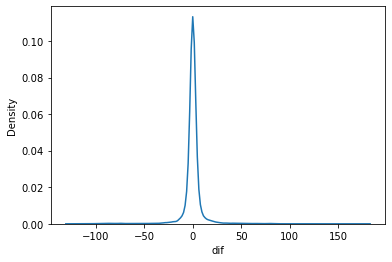

In [111]:
show = pd.DataFrame()
show['gt'] = y_test
show['pred'] = pred
show['dif'] = show['gt']-show['pred']
sns.kdeplot(show['dif'])


In [113]:
t= test_data
t['gt'] = show['gt']
t['pred'] = show['pred']
t.head()

,vehicleCode,lat,lng,velocity,distance,is_in_target,total_distance_mean_vehicle,left_distance,cum_sum_time,total_time,route_name,weekday,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday,left_time,gt,pred
31273,W102,35.535017,139.651147,0.000000,0.000000,0,112856.851854,122138.193257,0.0,42657.0,00W102,4,12.780346,8.063523,12.702903,49.704713,710,710,712.087958
31274,W102,35.534988,139.651211,0.018537,6.636338,0,112856.851854,122131.556919,358.0,42657.0,02W102,4,12.842753,10.408428,12.702903,49.704713,704,704,709.224480
31275,W102,35.534988,139.651211,0.000000,0.000000,0,112856.851854,122131.556919,359.0,42657.0,02W102,4,12.842753,10.408428,12.702903,49.704713,704,704,709.275554
31276,W102,35.534990,139.651403,0.028831,17.413900,0,112856.851854,122114.143019,963.0,42657.0,02W102,4,11.489974,7.494859,12.702903,49.704713,694,694,698.119580
31277,W102,35.535023,139.651470,0.004539,7.094093,0,112856.851854,122107.048926,2526.0,42657.0,02W102,4,10.716876,7.883613,12.702903,49.704713,668,668,671.411244


In [118]:
#Except Exceptional vehicleCode
adjust_mse = mean_squared_error(t[~t['vehicleCode'].isin(['W47-2'])]['pred'],t[~t['vehicleCode'].isin(['W47-2'])]['gt'])
adjust_r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(adjust_mse)}')
print(f'r2 : {adjust_r2}')

rmse : 9.340824596037129
r2 : 0.9983619446736846


### get insight from the modeling result

In [120]:
pd.cut(show.dif,[show['dif'].min(),-60,-30,-10,0,10,30,60,show['dif'].max()]).value_counts()/len(show)*100

(0.0, 10.0]          45.974920
(-10.0, 0.0]         44.582698
(10.0, 30.0]          3.641830
(-30.0, -10.0]        3.202919
(30.0, 60.0]          0.781149
(-129.248, -60.0]     0.746378
(-60.0, -30.0]        0.651555
(60.0, 181.28]        0.418513
Name: dif, dtype: float64

<AxesSubplot:>

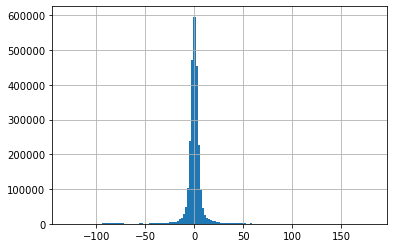

In [121]:
show['dif'].hist(bins=150)

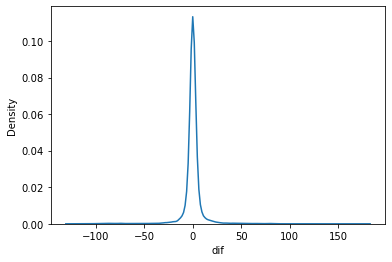

In [71]:
sns.kdeplot(show['dif'])


C:\Users\rkd20\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dif'>

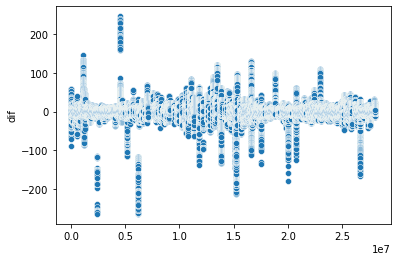

In [25]:
sns.scatterplot(show.index, show['dif'])

In [ ]:
explainer_1 = shap.Explainer(model1)
shap_values = explainer_1(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=10)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type='bar',max_display = 10)

In [3]:
importances = model1.feature_importances_
importances

array([1.55772148e-01, 1.37824166e-01, 3.13969173e-02, 1.41409981e-04,
       6.95004927e-05, 5.61439884e-04, 1.55146128e+00, 1.81101398e+01,
       3.30012373e+01, 4.53798126e+01, 1.24006282e+00, 1.30576993e-02,
       2.66302903e-01, 8.97036076e-04, 5.44998820e-02, 5.67631503e-02])

In [16]:
k = pd.DataFrame(columns = ['vehicleCode', 'lat', 'lng', 'velocity', 'distance', 'is_in_target','total_distance_mean_vehicle','left_distance', 'cum_sum_time', 'total_time','route_name','weekday', 'velocity_mean_5sec', 'velocity_std_5sec','velocity_mean_weekday', 'velocity_std_weekday'])


k

,vehicleCode,lat,lng,velocity,distance,is_in_target,total_distance_mean_vehicle,left_distance,cum_sum_time,total_time,route_name,weekday,velocity_mean_5sec,velocity_std_5sec,velocity_mean_weekday,velocity_std_weekday


In [17]:
k.shape

(0, 16)

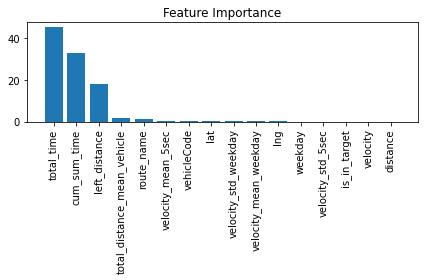

In [18]:

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(k.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(k.shape[1]), k.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [123]:
def show_temp(c):
    
    fig, ax1 = plt.subplots()
    n = t[t['course']==c]
    print(len(n))
    ax1 = sns.scatterplot(n.index,n['pred'], color = 'r', s= 2)
    ax1.plot
    ax2= ax1.twinx()
    ax2 = sns.scatterplot(n.index,n['gt'], s =2)
    plt.title("gt vs ourmodel")
